In [119]:
import pandas as pd
import numpy as np


# pymc3 with theano backend
import pymc3 as pm
import theano.tensor as tt

import scipy.stats as stats
import matplotlib.pyplot as plt

import datetime
import collections

# finance data from yahoo finance
import yfinance as yf

# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [120]:
# modify figure size
from IPython.core.pylabtools import figsize

# define fonts

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 19}

plt.rc('font', **font)

In [121]:
# same stock as previously

# finance
fin = ["IDCBY",
"HSBC",
"C",
"V",
"JPM",
"MA",
"BAC",
"IDCBF"]

# Healthcare
health = ["JNJ",
"RHHVF",
"NVS",
"MRK",
"PFE",
"ABT",
"BMY",
"MDT" ]

# Consumer goods
cons = ["AAPL",
"NSRGF",
"PG",
"PEP",
"TSM",
"INTC",
"KO",
"LVMUY"]

# Services
srv = ["AMZN",
"NFLX",
"WMT",
"UNH",
"HD",
"DIS",
"CMCSA",
"CHLKF"]

# Utilities
util = ["CVX",
"NEE",
"IBDRY",
"OJSCY",
"DUK",
"D",
"SO",
"AEP"]

#TECH
tech = ["MSFT",
"GOOGL",
"FB",
"VOD",
"ACN",
"T",
"CHT",
"VZ"]

# Industrial goods
ind = ["UTX",
"HON",
"LMT",
"EADSY",
"GE",
"SIEGY",
"MMM",
"CAT"]

# Random
others = ["XOM",
"BUD",
"NVO",
"BA",
"USB",
"IBM",
"ORCL",
"WFC"]

In [122]:
# combine stock information
stocks = fin+health+srv+ind+cons+util+tech+others

stock_dict = {'HEALTH':health,'IND':ind, 'UTIL':util,'FINANCE':fin,'TECH':tech,'SERVICE':srv,'CONSUM':cons,'OTHERS':others}

# back tranlation
stock_2_theme = {}
for key, val in stock_dict.items():
    for v in val:
        stock_2_theme[v] = key
    
# choose colors for the plots
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821","#345eeb", "#eb8f34", "#57514b", "#10d4de"]

stock_closes = pd.DataFrame()

enddate = "2019-02-22" #  ends one year ago 
startdate = '2014-1-1'

In [123]:
n_observations = 100 

In [124]:
# fetch stock information
for stock in stocks:
    tickerData = yf.Ticker(stock)
    x = tickerData.history(period='1d', start=startdate, end=enddate)
    stock_series = pd.Series(x['Close'].astype(float), name=stock)
    stock_closes[stock] = stock_series

In [126]:
stock_closes.columns

Index(['IDCBY', 'HSBC', 'C', 'V', 'JPM', 'MA', 'BAC', 'IDCBF', 'JNJ', 'RHHVF',
       'NVS', 'MRK', 'PFE', 'ABT', 'BMY', 'MDT', 'AMZN', 'NFLX', 'WMT', 'UNH',
       'HD', 'DIS', 'CMCSA', 'CHLKF', 'UTX', 'HON', 'LMT', 'EADSY', 'GE',
       'SIEGY', 'MMM', 'CAT', 'AAPL', 'NSRGF', 'PG', 'PEP', 'TSM', 'INTC',
       'KO', 'LVMUY', 'CVX', 'NEE', 'IBDRY', 'OJSCY', 'DUK', 'D', 'SO', 'AEP',
       'MSFT', 'GOOGL', 'FB', 'VOD', 'ACN', 'T', 'CHT', 'VZ', 'XOM', 'BUD',
       'NVO', 'BA', 'USB', 'IBM', 'ORCL', 'WFC'],
      dtype='object')

In [127]:
# normalization by delta percentage
stock_returns = stock_closes.pct_change()[1:][-n_observations:]

# list the stock indices
stock_returns.columns

Index(['IDCBY', 'HSBC', 'C', 'V', 'JPM', 'MA', 'BAC', 'IDCBF', 'JNJ', 'RHHVF',
       'NVS', 'MRK', 'PFE', 'ABT', 'BMY', 'MDT', 'AMZN', 'NFLX', 'WMT', 'UNH',
       'HD', 'DIS', 'CMCSA', 'CHLKF', 'UTX', 'HON', 'LMT', 'EADSY', 'GE',
       'SIEGY', 'MMM', 'CAT', 'AAPL', 'NSRGF', 'PG', 'PEP', 'TSM', 'INTC',
       'KO', 'LVMUY', 'CVX', 'NEE', 'IBDRY', 'OJSCY', 'DUK', 'D', 'SO', 'AEP',
       'MSFT', 'GOOGL', 'FB', 'VOD', 'ACN', 'T', 'CHT', 'VZ', 'XOM', 'BUD',
       'NVO', 'BA', 'USB', 'IBM', 'ORCL', 'WFC'],
      dtype='object')

In [128]:
# reduce autocorrelation by thinning data 
blocks = 5
block_dict = {}
for n in range(blocks):
    idx = [(it * blocks)+n for it in range(stock_returns.shape[0]// blocks) ]
    
    block_dict[n] = stock_closes.iloc[idx] # use stock close data
    
    block_dict[n] = block_dict[n].pct_change()[1:][-n_observations:] # convert to weekwise delta

In [109]:
# choose a block for preparation
prep_stock = block_dict[2]

In [10]:
def cov_to_corr(A):
    """
    Transform covariance to correlation
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    return A

In [28]:
# choose a stock to begin with
# Try "PG"
seed_share = pd.DataFrame(stock_returns.sum().sort_values(ascending=False) ).iloc[0].name

# For the time period chosen that was PG, which is in the group Consumer goods

In [58]:
stem_shares =  pd.DataFrame(stock_returns  
                            .corr()[seed_share] # correlation to the seed
                            .sort_values()) # sort

In [65]:
stem_shares = stem_shares.index.to_series().map(stock_2_theme) # add information on group

In [67]:
stem_shares = pd.DataFrame(stem_shares.drop_duplicates()) # remove additional shares

In [70]:
# the most highly correlated shares by subject group
stem_shares = stem_shares.loc[stem_shares[0] != stock_2_theme[seed_share]]

In [74]:
test_portfolio = stem_shares.index.tolist() + [seed_share ]

In [75]:
test_portfolio

['IDCBF', 'CHLKF', 'OJSCY', 'EADSY', 'CHT', 'NVO', 'BMY', 'PG']

In [76]:
# again we need priors
prior_expectations = {}
for ind, stocks in stock_dict.items():#[health,ind, util,fin,tech,srv,cons,others]:
    prior_expectations[ind] = (stock_returns[stocks].mean(axis=1).mean() , stock_returns[stocks].mean(axis=1).std())
    #print(ind, stock_returns[stocks].mean(axis=1).mean() , stock_returns[stocks].mean(axis=1).std()  )

In [84]:
def specific_stock(combination):
    
    priormus = [] 
    priorstd = []
    
    for i, (key, val) in enumerate(stock_dict.items()):
        priormus.append(prior_expectations[key][0])
        priorstd.append(prior_expectations[key][1])
        
    stock_relevant = stock_returns[combination]
    covar = stock_relevant.cov()
    return stock_relevant, np.asarray(covar), np.array(priormus), np.array(priorstd)

In [118]:
block_dict[0]

,XOM,BUD,NVO,BA,USB,IBM,ORCL,WFC
Date,,,,,,,,
2014-01-08,-0.004502,-0.014334,0.02493,0.031704,0.017241,0.002123,-0.011204,0.011482
2014-01-15,-0.019470,-0.017313,0.01581,-0.001423,0.009887,-0.001230,0.018303,0.010560
2014-01-23,-0.018319,-0.006695,-0.00449,0.004947,-0.018741,-0.026681,-0.006562,-0.001306


In [129]:
# analyze the stock

# we have 5 subsets to analyze the data on after thinning the data above

blocktrace = {}

for block, block_data in block_dict.items():

    stock_returns = pd.DataFrame(block_data)

    stocks_chosen, init, prior_mu, prior_std = specific_stock(test_portfolio)

    with pm.Model() as model:
    
        covar = pm.WishartBartlett('covar', np.diag(prior_std**2), nu=16, testval=init)
    
        mu = pm.Normal('returns', mu=prior_mu, sd=1, shape= prior_mu.shape[0] )

        obs = pm.MvNormal('observed returns', mu=mu, cov = covar, observed=stocks_chosen)
    
        step = pm.NUTS()
        trace = pm.sample(10000, step=step)
        
        blocktrace[block] = trace
        

Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 561.24draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:14<00:00, 562.36draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns, covar_z, covar_c]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:17<00:00, 542.08draws/s]
Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
Multiprocess samp

In [130]:
mu_samples = [trace["returns"] for block, trace in blocktrace.items()]

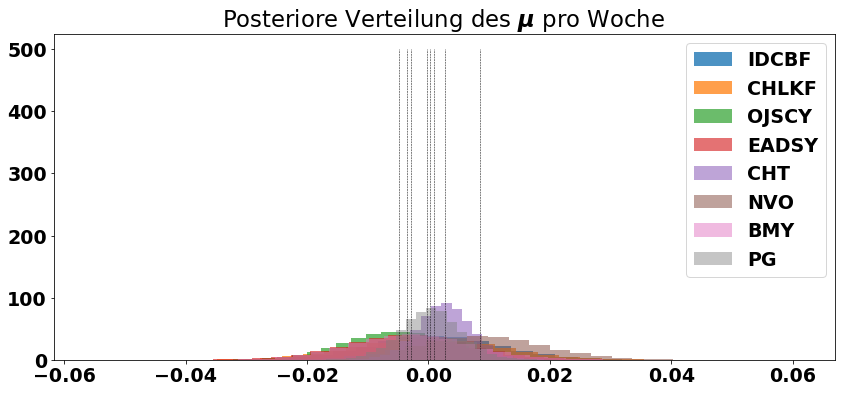

In [137]:

figsize(14,6)

#examine the mean return first.
mu_samples = trace["returns"]

for i in range(8):
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", normed=True, 
             label = "%s" % test_portfolio[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth = .5)

plt.title("Posteriore Verteilung des $\mu$ pro Woche ")
plt.legend();

In [144]:
np.stack([trace["covar"] for block, trace in blocktrace.items()] ).shape

(40000, 5, 8, 8)

In [145]:
np.concatenate(blocktrace[0], blocktrace[1])

TypeError: 'MultiTrace' object cannot be interpreted as an integer

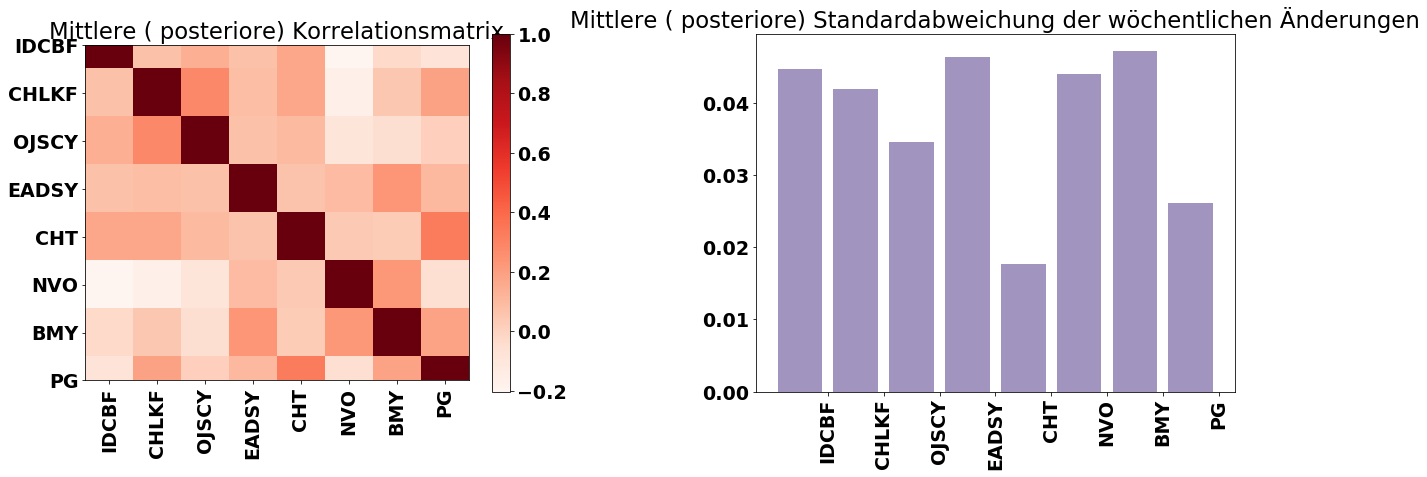

In [147]:
figsize(20,7)
cov_samples = blocktrace[1]["covar"]
mean_covariance_matrix = cov_samples.mean(axis=0)

def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix) , interpolation="none", 
                cmap = "Reds") 
plt.xticks(np.arange(8), test_portfolio,rotation='vertical')
plt.yticks(np.arange(8), test_portfolio)
plt.colorbar(orientation="vertical")
plt.title("Mittlere ( posteriore) Korrelationsmatrix")

plt.subplot(1,2,2)
plt.bar(np.arange(8), np.sqrt(np.diag(mean_covariance_matrix)),
        color = colors[2], alpha = 0.7)
plt.xticks(np.arange(8) + 0.5, test_portfolio,rotation='vertical');
plt.title("Mittlere ( posteriore) Standardabweichung der wöchentlichen Änderungen")

plt.tight_layout();

In [149]:
# iteratively replace the worst stock
mean_covariance_matrix.shape

(8, 8)